In [11]:
import pennylane as qml
from matplotlib import pyplot as plt
from pennylane import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import display
from tqdm.notebook import tqdm
from collections import deque

from models.agentQVC import AgentQVC
from utils.maze import *

np.random.seed(42)

In [12]:
# Setting up maze environment
maze_width=4
maze_height=4
maze_layout=np.zeros((maze_height, maze_width))
maze_display=[[" " for i in range(maze_width)] for j in range(maze_height)]

# # environment for 8 x 8 (H x W)
# maze_display[0][0]='R'
# maze_layout[0][0]=100
# maze_display[5][4]='r'
# maze_layout[5][4]=20
# maze_display[2][4]='r'
# maze_layout[2][4]=20
# maze_display[0][7]='r'
# maze_layout[0][7]=20
# maze_display[2][3]='P'
# maze_layout[2][3]=-100
# maze_display[6][3]='P'
# maze_layout[6][3]=-100
# maze_display[2][6]='P'
# maze_layout[2][6]=-100
# maze_display[0][1]='W'
# maze_display[1][1]='W'
# maze_display[2][1]='W'
# maze_display[3][1]='W'

# environment for 4 x 4 (H x W)
maze_display[0][0]='R'
maze_layout[0][0]=50
maze_display[0][1]='P'
maze_layout[0][1]=-100
maze_display[1][1]='P'
maze_layout[1][1]=-100
maze_display[2][1]='P'
maze_layout[2][1]=-100
maze_display[0][3]='r'
maze_layout[0][3]=10

# # environment for 2 x 2 (H x W)
# maze_display[0][0]='R'
# maze_layout[0][0]=100
# maze_display[0][1]='P'
# maze_layout[0][1]=-50

# print out the maze
print("Maze layout:")
for i in range(len(maze_display)):
    print(maze_display[i])

print()
print("Maze reward:")
print(maze_layout)

Maze layout:
['R', 'P', ' ', 'r']
[' ', 'P', ' ', ' ']
[' ', 'P', ' ', ' ']
[' ', ' ', ' ', ' ']

Maze reward:
[[  50. -100.    0.   10.]
 [   0. -100.    0.    0.]
 [   0. -100.    0.    0.]
 [   0.    0.    0.    0.]]


In [13]:
print(np.shape(maze_display))
print(np.shape(maze_layout))
maze=Maze(maze_display,maze_layout)

(4, 4)
(4, 4)


In [14]:
# configurations
numFrame=50
numSucceed=1000 # number of epochs it reaches the target
numEpoch=int(100000)
numRecordStep=int(1000)

alpha=0.1
gamma=0.9 
epsilon_max=1.0
epsilon_min=0.5
epsilon_halflife=300
memory_size=1000
memory_sampling=10
update_freq=20

depth = 2 # number of layers in unitary matrix of quantum circuit
numQubits_width = int(math.log(maze_width,2))
numQubits_height = int(math.log(maze_height,2))
numQubits = numQubits_width+numQubits_height
# Initialize the parameters, with Gaus(0, 0.1) distribution
# init_weights = 0.1 * np.array(np.random.randn(depth, numQubits, 3), requires_grad=True)
# init_bias = 0.1 * np.array(np.random.randn(numQubits), requires_grad=True)
init_params = 0.1 * np.array(np.random.randn(depth * numQubits * 3 + len(maze.action_space())), requires_grad=True)

In [15]:
# defining a basic block
def layer(W):
    for j in range(numQubits - 1):
        qml.CNOT(wires=[j, j + 1])
    for i in range(numQubits):
        qml.Rot(W[i, 0], W[i, 1], W[i, 2], wires=i)
        
# defining the quantum circuit, in which the number of layers depends on the number of weights taken
def circuit(weights, state=None):
    if((state==np.ones(numQubits)).all()):
        for i in range(numQubits):
            qml.PauliX(i)
    elif((state==np.zeros(numQubits)).all()):
        pass
    else:
        qml.templates.embeddings.BasisEmbedding(np.array(state, requires_grad=False), wires=range(numQubits))
    for W in weights:
        layer(W)
    return qml.expval(qml.PauliZ(0)),qml.expval(qml.PauliZ(1)),qml.expval(qml.PauliZ(2)),qml.expval(qml.PauliZ(3))

dev = qml.device("default.qubit", wires=numQubits)
qcircuit = qml.QNode(circuit, dev)

# defining a variational circuit for each one-vs-all classifier, where an additional classical bias term is added
def variational_learner(params, state):
    weights = params[:depth * numQubits * 3]
    weights = weights.reshape(depth, numQubits, 3)
    bias = params[-len(maze.action_space()):]
    return qcircuit(weights, state=state) + bias

agent=AgentQVC(maze, variational_learner, init_params, alpha=alpha, gamma=gamma, epsilon_max=epsilon_max, epsilon_min=epsilon_min, epsilon_halflife=epsilon_halflife, memory_size=memory_size, memory_sampling=memory_sampling, update_freq=update_freq)


In [16]:
def run_episode(env, agent):  
    """Runs the env for a certain amount of steps with the given parameters. Returns the reward obtained"""
    state = env.reset()
    totalreward = 0
    for _ in range(numFrame):
        state, reward, done = agent.train(state)  
        totalreward += reward
        if done:
            break
    return totalreward, done


In [17]:
epoch_list=[]
reward_list=[]
reward_microlist=[]
bestreward = 0
succeed = 0

agent.train_mode(True)
with tqdm(total=numSucceed, desc='Number of success', position=0) as succeedbar:
    for i in tqdm(range(numEpoch), desc='Epoch', position=1):  
        reward, done = run_episode(maze, agent)
        reward_microlist.append(reward.item())
        if reward > bestreward:
            bestreward = reward
            # considered solved if the agent lasts for the required number of timesteps
#         if(done):
        if(reward > 40):
            succeed+=1
            succeedbar.update(1)
            if(succeed==numSucceed):
                break
        if(i%numRecordStep==0):
            reward_list.append(np.mean(reward_microlist))
            epoch_list.append(i)
            reward_microlist=[]
        
if (succeed==numSucceed):
    print("Finished running and solution found in epoch # {}! =D \n".format(i)) # first epoch starts from label 0
elif (succeed!=0):
    print("Finished running and didn't meet requirement, but solution was found {} times. =) \n".format(numSucceed)) # first epoch starts from label 0
else:
    print("Finished running but solution not found. =\\ \n")
print("The best reward was {} steps.".format(bestreward))
        
print("#################################")
print("#                               #")
print("#        Done training!!        #")
print("#                               #")
print("#################################")



Finished running and didn't meet requirement, but solution was found 1000 times. =) 

The best reward was 44.0 steps.
#################################
#                               #
#        Done training!!        #
#                               #
#################################


(-479.98040000000003, -251.2916)

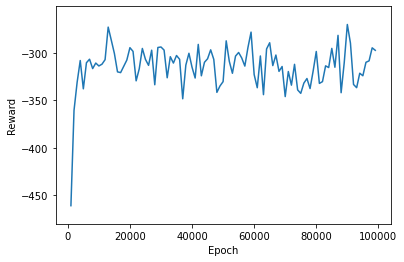

In [18]:
plt.plot(epoch_list[1:], reward_list[1:])
plt.xlabel("Epoch")
plt.ylabel("Reward")
maximum=np.amax(reward_list[1:])
minimum=np.amin(reward_list[1:])
diff=maximum-minimum
plt.ylim([minimum-diff*.1,maximum+diff*.1])
# plt.savefig('reward_vs_epoch.png')
# del epoch_list, reward_list